# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Set visual style for plots
sns.set(style="whitegrid")

function for downcasting, and we will need for optimization

In [3]:
def downcaste_dtype(df):
    previous_memory_consumption = (df.memory_usage().sum()) / 1024**2 
    for col in df.columns:
        col_dtype = df[col].dtypes
        if col_dtype != 'object':
            xmin = df[col].min()
            xmax = df[col].max()
            if str(col_dtype)[0] == 'i': 
                if np.iinfo('int8').min < xmin and np.iinfo('int8').max > xmax:
                    df[col] = df[col].astype('int8')
                elif np.iinfo('int16').min < xmin and np.iinfo('int16').max > xmax:
                    df[col] = df[col].astype('int16')
                elif np.iinfo('int32').min < xmin and np.iinfo('int32').max > xmax:
                    df[col] = df[col].astype('int32')
                elif np.iinfo('int64').min < xmin and np.iinfo('int64').max > xmax:
                    df[col] = df[col].astype('int64')
                    
            elif str(col_dtype)[0] == 'f': 
                if np.finfo('float16').min < xmin and np.finfo('float16').max > xmax:
                    df[col] = df[col].astype('float16')
                elif np.finfo('float32').min < xmin and np.finfo('float32').max > xmax:
                    df[col] = df[col].astype('float32')
                elif np.finfo('float64').min < xmin and np.finfo('float64').max > xmax:
                    df[col] = df[col].astype('float64')
            else:
                pass

    after_memory_consumption = (df.memory_usage().sum()) / 1024**2
    percentage_of_decrease = ((previous_memory_consumption - after_memory_consumption) / previous_memory_consumption) * 100

    print('Memory usage before downcasting: {:.2f} MB'.format(previous_memory_consumption))
    print('After Downcasting the memory usage decreased to: {:.2f} MB'.format(after_memory_consumption))
    print('Memory usage decreased by {:.3f}%'.format(percentage_of_decrease))

    return df

# Load the datasets

In [4]:
previous_credits = pd.read_csv('../DataSet/previous_credits.csv')
credit_bureau_balance = pd.read_csv('../DataSet/credit_bureau_balance.csv')

In [5]:
previous_credits = downcaste_dtype(previous_credits)
credit_bureau_balance = downcaste_dtype(credit_bureau_balance)

Memory usage before downcasting: 222.62 MB
After Downcasting the memory usage decreased to: 112.95 MB
Memory usage decreased by 49.265%
Memory usage before downcasting: 624.85 MB
After Downcasting the memory usage decreased to: 338.46 MB
Memory usage decreased by 45.833%


# merging datasets

In [6]:
merged_data = pd.merge(previous_credits, credit_bureau_balance, on='sk_id_bureau', how='left')

# Data Cleaning and Preprocessing

In [7]:
# Checking for missing values
missing_values = merged_data.isnull().sum()

# Handling missing values
merged_data['amt_credit_sum'].fillna(merged_data['amt_credit_sum'].median(), inplace=True)
merged_data['status'].fillna(merged_data['status'].mode()[0], inplace=True)

# Exploratory Data Analysis (EDA)

Summary statistics

In [8]:
summary = merged_data.describe()

Distribution of key numerical features

In [11]:
# merged_data.hist(bins=15, figsize=(15, 10), edgecolor='black')
# plt.subplots_adjust(hspace=0.5)

Heatmap for Credit Amount vs. Status

Text(0.5, 1.0, 'Average Credit Amount by Credit Status and Activity')

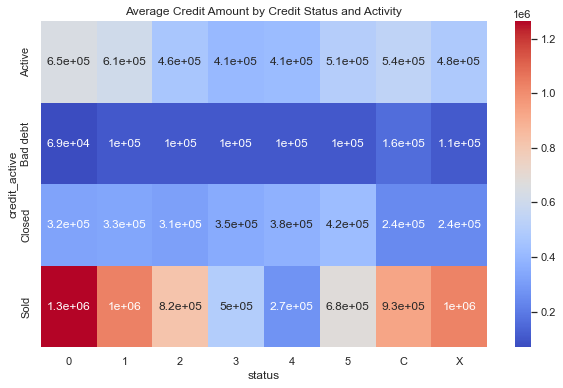

In [12]:
pivot_table = merged_data.pivot_table(values='amt_credit_sum', index='credit_active', columns='status', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Average Credit Amount by Credit Status and Activity')

Correlation analysis

Text(0.5, 1.0, 'Correlation Matrix')

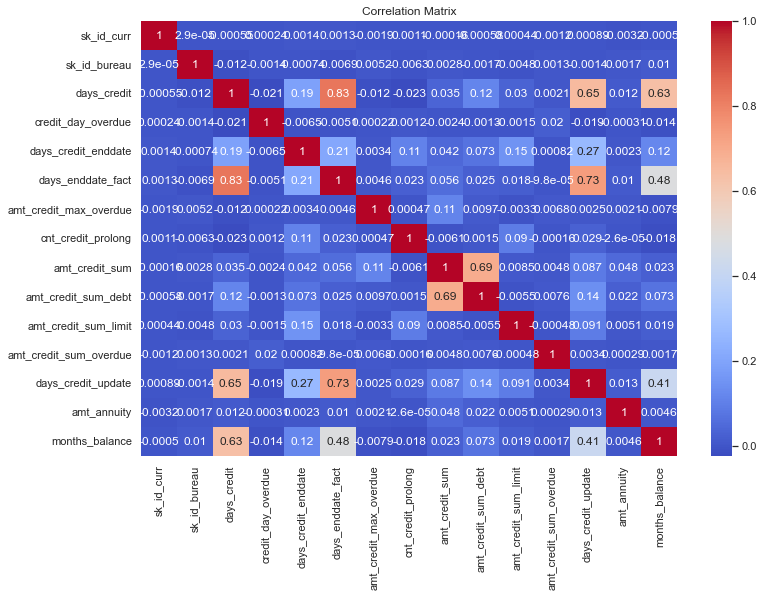

In [13]:
correlation_matrix = merged_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

# Aggregation and Grouping

In [14]:
# Average credit amount by credit type
avg_credit_by_type = merged_data.groupby('credit_type')['amt_credit_sum'].mean()

# Total credit amount by credit active status
total_credit_by_status = merged_data.groupby('credit_active')['amt_credit_sum'].sum()

# Count of credits by credit type and active status
count_credits = merged_data.groupby(['credit_type', 'credit_active']).size().reset_index(name='count')

# Average monthly balance by status
avg_monthly_balance_by_status = credit_bureau_balance.groupby('status')['months_balance'].mean()

# Maximum overdue amount in credit bureau data
max_overdue = previous_credits.groupby('sk_id_bureau')['amt_credit_max_overdue'].max()

# Multi-level aggregation
agg_data = previous_credits.groupby('credit_active').agg({'amt_credit_sum': 'mean', 
                                                         'amt_credit_max_overdue': 'max'}).reset_index()

# Visualization of Aggregated Data

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Another type of loan'),
  Text(1, 0, 'Car loan'),
  Text(2, 0, 'Cash loan (non-earmarked)'),
  Text(3, 0, 'Consumer credit'),
  Text(4, 0, 'Credit card'),
  Text(5, 0, 'Interbank credit'),
  Text(6, 0, 'Loan for business development'),
  Text(7, 0, 'Loan for purchase of shares (margin lending)'),
  Text(8, 0, 'Loan for the purchase of equipment'),
  Text(9, 0, 'Loan for working capital replenishment'),
  Text(10, 0, 'Microloan'),
  Text(11, 0, 'Mobile operator loan'),
  Text(12, 0, 'Mortgage'),
  Text(13, 0, 'Real estate loan'),
  Text(14, 0, 'Unknown type of loan')])

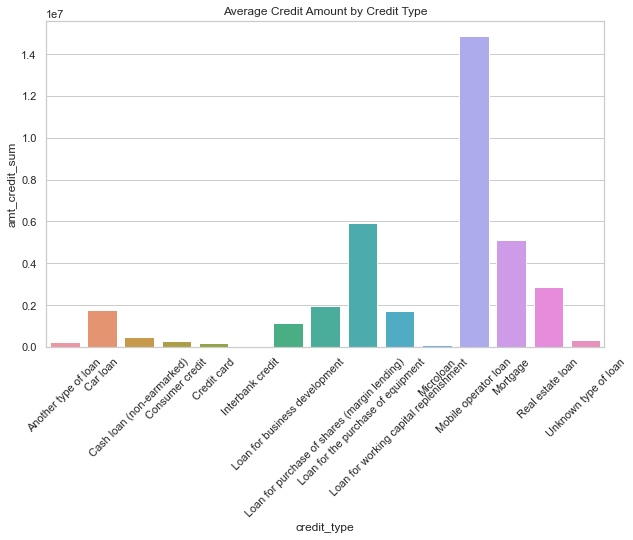

In [15]:
# Bar plot for average credit by type
plt.figure(figsize=(10, 6))
sns.barplot(x='credit_type', y='amt_credit_sum', data=avg_credit_by_type.reset_index())
plt.title('Average Credit Amount by Credit Type')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Another type of loan'),
  Text(1, 0, 'Car loan'),
  Text(2, 0, 'Cash loan (non-earmarked)'),
  Text(3, 0, 'Consumer credit'),
  Text(4, 0, 'Credit card'),
  Text(5, 0, 'Interbank credit'),
  Text(6, 0, 'Loan for business development'),
  Text(7, 0, 'Loan for purchase of shares (margin lending)'),
  Text(8, 0, 'Loan for the purchase of equipment'),
  Text(9, 0, 'Loan for working capital replenishment'),
  Text(10, 0, 'Microloan'),
  Text(11, 0, 'Mobile operator loan'),
  Text(12, 0, 'Mortgage'),
  Text(13, 0, 'Real estate loan'),
  Text(14, 0, 'Unknown type of loan')])

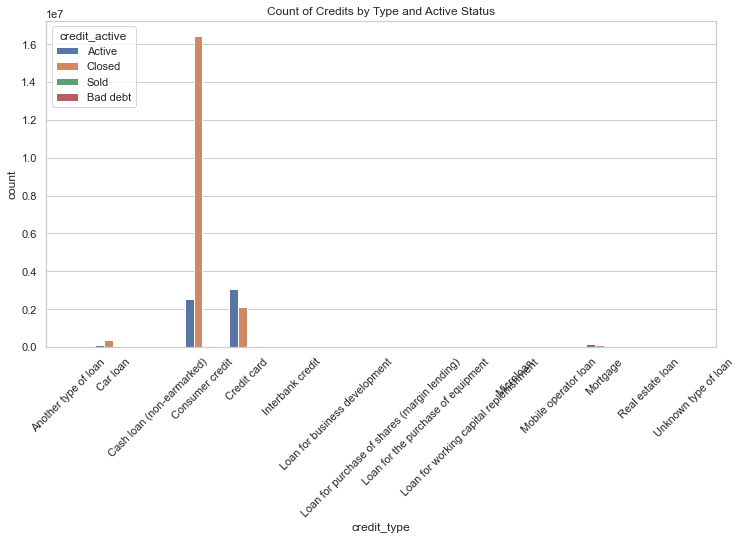

In [16]:
# Bar plot for count of credits
plt.figure(figsize=(12, 6))
sns.barplot(x='credit_type', y='count', hue='credit_active', data=count_credits)
plt.title('Count of Credits by Type and Active Status')
plt.xticks(rotation=45)

using Z-score for Credit Amount, for outlier detection

In [17]:
merged_data['credit_amount_z_score'] = np.abs(stats.zscore(merged_data['amt_credit_sum']))
outliers = merged_data[merged_data['credit_amount_z_score'] > 3]